# Notebook for generating figures, tables, and (light!) postprocessing analysis for the June 2024 analysis of the Rhodium Group's 2024 CCS installation capacity projections

Lindsey Gulden, June 2024 for the Science Roundtable
Updated for August 2024 submission of CRCJ paper.

Various figures for assorted presentations and blog posts (e.g., the RHG blog post on SRCCS web page) are at the top.

CRCJ stats and figures are at the bottom of this notebook

Note that paths to data for figures/tables can be found in the linked YAML file:

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import seaborn as sns
import datetime as dt
from utils.data import rgb_tuple
from scipy.stats import percentileofscore

import geopandas as gpd

import warnings
import geopandas as gpd
from pathlib import Path

# Project parameters for RHG cases:
from pathlib import Path
from utils.io import yaml_to_dict

warnings.filterwarnings("ignore")
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


### Conversions to assist merging data

In [55]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

### Path to configuration file specifying file paths of data to be plotted below

In [56]:
ROOT_DIR = Path("/Users/lindseygulden/dev/leg-up-private/")

# Get paths to data to be used for figures and post-processing
config = yaml_to_dict(
    ROOT_DIR / Path("config/ccs/fig_data_locs.yml"),
)

### Set color palette such that color associated with a given industry matches the color used in Figure 3 of the RHG 2024 report

In [57]:
palette = {
    "Ethanol": rgb_tuple(68, 133, 189),
    "Ammonia": rgb_tuple(224, 182, 96),
    "NG Processing": rgb_tuple(211, 126, 87),
    "Refinery": rgb_tuple(99, 188, 200),
    "Hydrogen": rgb_tuple(84, 147, 127),
    "Ethylene": rgb_tuple(88, 83, 111),
    "Iron/Steel": rgb_tuple(110, 113, 114),
    "Cement": rgb_tuple(115, 167, 208),
    "Rooftop Solar": rgb_tuple(10, 120, 30),
}

### Get the data!

In [58]:
solar_df = pd.read_csv(config["solar_project_results_file"], index_col=[0])

# Read adjusted oil-price data (converted to 2023 dollars already by command-line script)
brent_df = pd.read_csv(
    config["path_to_brent_data"],
    parse_dates=["date"],
    dtype={"year": int},
)
# get parameters for breakeven prices' triangular distributions
breakeven_prices_df = pd.read_csv(
    config["path_to_breakeven_data"],
    index_col=[0],
)
# get all industries' facilities locaiton data
all_industries_gdf = gpd.read_file(config["path_to_all_facility_locations_data"])

# import representative lat/lon points for the npc storage regions
storage_gdf = gpd.read_file(config["path_to_npc_storage_regions_data"])

# import costs data
costs_df = pd.read_csv(config["ccs_costs_file"], index_col="industry")
industries = list(costs_df.index)

# import digitized RHG oil cases
rhg_oil_cases_df = pd.read_csv(config["rhg_oil_cases_file"])

# import digitized RHG projections for 2040
rhodium_2040_df = pd.read_csv(config["rhg_2040_projections_file"])

# get unit-economics simulator cases
scenarios_df = pd.read_csv(
    config["path_to_ues_simulations"],
    dtype={"brent_since_yr": str},
    index_col=[0],
)

# get approximations of high-mid-low RHG scenarios run with UES
# rhg_scenarios_df = pd.read_csv(config["rhg_scenarios_with_ues"], index_col=[0])
rhg_scenarios_df = pd.read_csv(config["rhg_scenarios_with_ues"])

Average project-lifetime NPV of rooftop solar (USD): 7895.02
Average project-lifetime NPV of rooftop solar (USD/tCO2 averted): 74.45


### Single-panel figure Figure showing time series of Brent prices (both daily and the 365-day rolling mean), all adjusted to 2023 dollars

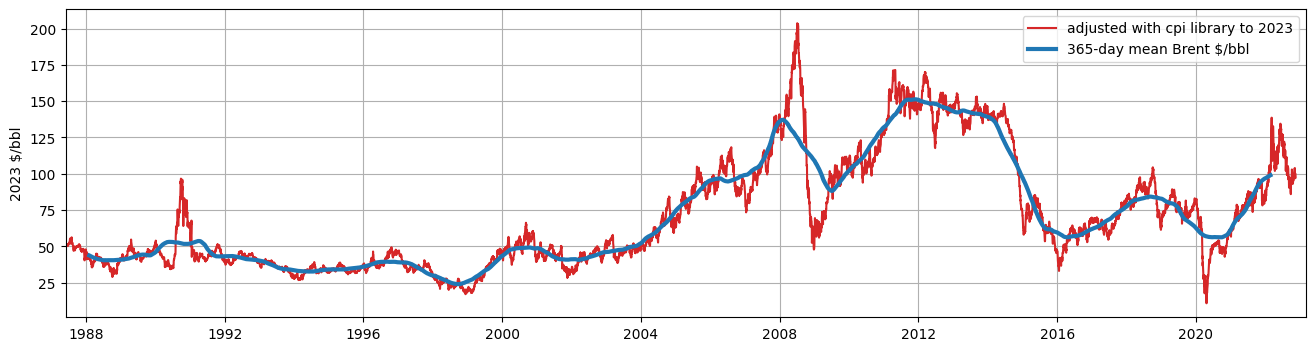

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.subplot(1, 1, 1)
plt.plot(
    brent_df.date,
    brent_df.usd_cpi_2023,
    color="tab:red",
    lw=1.5,
    label="adjusted with cpi library to 2023",
)
plt.plot(
    brent_df.date,
    brent_df.rolling_annual_average_usd_per_unit,
    color="tab:blue",
    lw=3,
    label="365-day mean Brent $/bbl",
)
plt.grid(True)
plt.ylabel("2023 $/bbl")
plt.legend()
plt.xlim([dt.datetime(1987, 6, 1), dt.datetime(2023, 3, 1)])


### Figure showing lack of realism of RHG's oil price cases -- side by side comparison of their casees with real Brent price data

Text(0, 0.5, '')

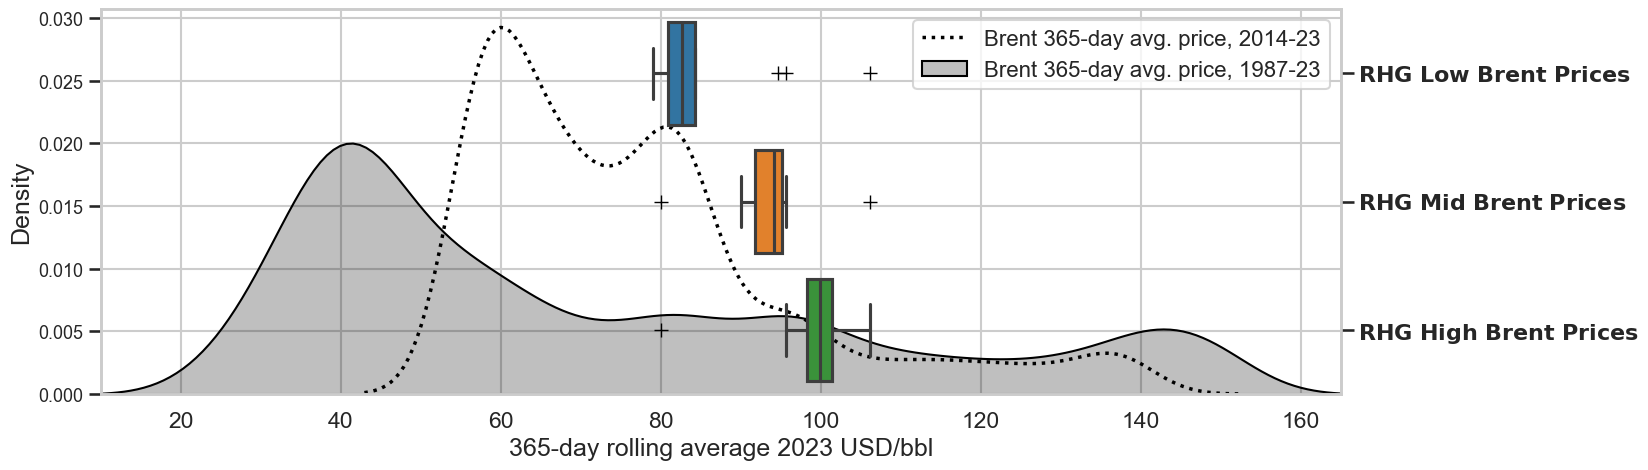

In [116]:
# Turn rhg oil price cases into a long-form dataset so that we can use seaborn's hue functionalty
rhg_cases_longform_df = rhg_oil_cases_df.melt(
    value_vars=["low", "mid", "high"],
    value_name="usd_per_bbl",
    var_name="rhg_emissions_case",
)

common_norm = False
sns.set_context("talk")
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
ax.set_xlim([10, 165])
sns.kdeplot(
    data=brent_df.loc[(brent_df["year"] > 2013)],
    x="rolling_annual_average_usd_per_unit",
    common_norm=common_norm,
    fill=False,
    ax=ax,
    ls=":",
    lw=2.5,
    color="black",
    label="Brent 365-day avg. price, 2014-23",
)


sns.kdeplot(
    data=brent_df.loc[(brent_df["year"] > 1986)],
    x="rolling_annual_average_usd_per_unit",
    common_norm=common_norm,
    fill=True,
    ax=ax,
    color="black",
    label="Brent 365-day avg. price, 1987-23",
)

ax2 = ax.twinx()

flierprops = dict(
    marker="+", markerfacecolor="None", markersize=10, markeredgecolor="black"
)


sns.boxplot(
    data=rhg_cases_longform_df,
    x="usd_per_bbl",
    y="rhg_emissions_case",
    ax=ax2,
    flierprops=flierprops,
)
l = ax.get_yticklabels()
ax.set_yticklabels(l, fontsize=13)
ax.legend(fontsize=16)
ax.grid(True)
ax.set_xlabel("365-day rolling average 2023 USD/bbl")

ax2.set_yticklabels(
    [
        r"$\bf{" + "RHG\ Low\ Brent\ Prices" + "}$",
        r"$\bf{" + "RHG\ Mid\ Brent\ Prices" + "}$",
        r"$\bf{" + "RHG\ High\ Brent\ Prices" + "}$",
    ],
    fontsize=16,
)
ax2.set_ylabel("")

### Report relative stats for comparing Rhodium price cases to historical record

In [117]:
print("Mean prices for each of the Rhodium oil-price cases: ")
print(rhg_cases_longform_df.groupby("rhg_emissions_case").mean())
print("")
median_since_87 = brent_df.rolling_annual_average_usd_per_unit.median()
print(
    f"Median 365-day rolling-window average Brent price (all days since mid 1987): {median_since_87:.2f}"
)
median_since_14 = brent_df.loc[
    brent_df.year > 2013
].rolling_annual_average_usd_per_unit.median()
print(
    f"Median 365-day rolling-window average Brent price (all days since Jan 1, 2014): {median_since_14:.2f}"
)
high_oil_mean = (
    rhg_cases_longform_df.groupby("rhg_emissions_case")
    .mean()
    .loc["high", "usd_per_bbl"]
)
percentile_above = percentileofscore(
    list(brent_df.rolling_annual_average_usd_per_unit.dropna()), high_oil_mean
)
print(
    f"Percentile of since-1987 Brent prices into which the high-oil-price mean price falls: {percentile_above:.2f}"
)


print("")

Mean prices for each of the Rhodium oil-price cases: 
                    usd_per_bbl
rhg_emissions_case             
high                  98.933333
low                   85.274667
mid                   93.421333

Median 365-day rolling-window average Brent price (all days since mid 1987): 57.05
Median 365-day rolling-window average Brent price (all days since Jan 1, 2014): 72.48
Percentile of since-1987 Brent prices into which the high-oil-price mean price falls: 78.70



### Figure (re)plotting total 2040 Capacity MMtCO2 for each of the three emissions scenarios 
as reported in Fig. 3 of the 2024 RHG report

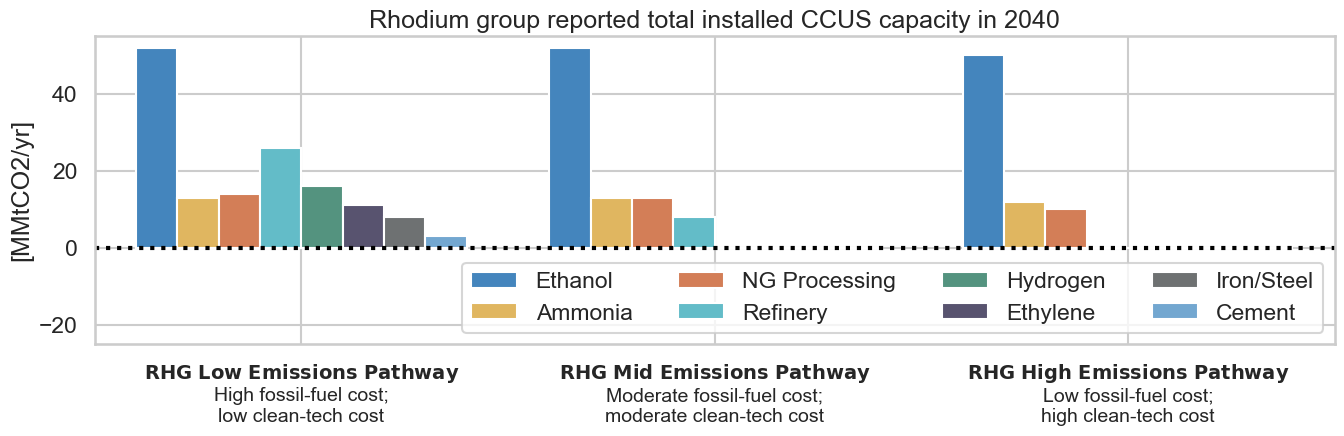

In [38]:
sns.set_style("whitegrid", {"axes.grid": True})
sns.set_context("talk")

palette = {
    "Ethanol": rgb_tuple(68, 133, 189),
    "Ammonia": rgb_tuple(224, 182, 96),
    "NG Processing": rgb_tuple(211, 126, 87),
    "Refinery": rgb_tuple(99, 188, 200),
    "Hydrogen": rgb_tuple(84, 147, 127),
    "Ethylene": rgb_tuple(88, 83, 111),
    "Iron/Steel": rgb_tuple(110, 113, 114),
    "Cement": rgb_tuple(115, 167, 208),
}
hue_order = list(palette.keys())
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.barplot(
    ax=ax,
    data=rhodium_2040_df,
    x="rhg_emissions_pathway",
    y="MMtCO2_per_yr",
    hue="industry",
    palette=palette,
    hue_order=hue_order,
    saturation=1,
)
plt.plot([-0.5, 2.5], [0, 0], "k", lw=3, ls=":")
ax.set_xlim([-0.5, 2.5])
ax.grid(True)
labels = ax.get_xticklabels()
ax.set_xticklabels(
    [
        r"$\bf{"
        + "RHG\ Low\ Emissions\ Pathway"
        + "}$"
        + "\nHigh fossil-fuel cost;\nlow clean-tech cost",
        r"$\bf{"
        + "RHG\ Mid\ Emissions\ Pathway"
        + "}$"
        + "\nModerate fossil-fuel cost;\nmoderate clean-tech cost",
        r"$\bf{"
        + "RHG\ High\ Emissions\ Pathway"
        + "}$"
        + "\nLow fossil-fuel cost;\nhigh clean-tech cost",
    ],
    fontsize=14,
)
ax.set_xlabel("")
ax.set_ylim([-25, 55])
ax.set_ylabel("[MMtCO2/yr]")
ax.set_title("Rhodium group reported total installed CCUS capacity in 2040")
ax.legend(loc="lower right", ncol=4)

### Figure showing the CCS-EOR present unit value for each industry as simluated by UES for each RHG scenario

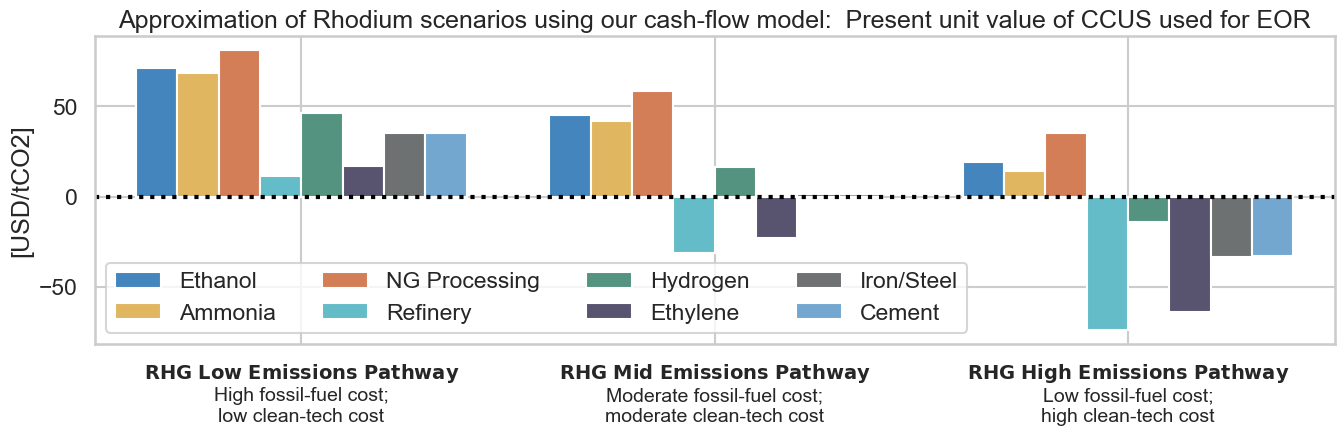

In [15]:
sns.set_style("whitegrid", {"axes.grid": True})
sns.set_context("talk")

palette = {
    "Ethanol": rgb_tuple(68, 133, 189),
    "Ammonia": rgb_tuple(224, 182, 96),
    "NG Processing": rgb_tuple(211, 126, 87),
    "Refinery": rgb_tuple(99, 188, 200),
    "Hydrogen": rgb_tuple(84, 147, 127),
    "Ethylene": rgb_tuple(88, 83, 111),
    "Iron/Steel": rgb_tuple(110, 113, 114),
    "Cement": rgb_tuple(115, 167, 208),
}
hue_order = list(palette.keys())
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.barplot(
    ax=ax,
    data=rhg_scenarios_df,
    x="rhg_emissions_pathway",
    y="total_eor_usd_per_tco2",
    hue="industry",
    palette=palette,
    hue_order=hue_order,
    saturation=1,
)
plt.plot([-0.5, 2.5], [0, 0], "k", lw=3, ls=":")
ax.set_xlim([-0.5, 2.5])
ax.grid(True)
labels = ax.get_xticklabels()
ax.set_xticklabels(
    [
        r"$\bf{"
        + "RHG\ Low\ Emissions\ Pathway"
        + "}$"
        + "\nHigh fossil-fuel cost;\nlow clean-tech cost",
        r"$\bf{"
        + "RHG\ Mid\ Emissions\ Pathway"
        + "}$"
        + "\nModerate fossil-fuel cost;\nmoderate clean-tech cost",
        r"$\bf{"
        + "RHG\ High\ Emissions\ Pathway"
        + "}$"
        + "\nLow fossil-fuel cost;\nhigh clean-tech cost",
    ],
    fontsize=14,
)
ax.set_xlabel("")
ax.set_ylabel("[USD/tCO2]")
ax.set_title(
    "Approximation of Rhodium scenarios using our cash-flow model:  Present unit value of CCUS used for EOR"
)
ax.legend(loc="lower left", ncols=4)

### Figure showing the CCS-GS present unit value for each industry as simluated by UES for each RHG scenario

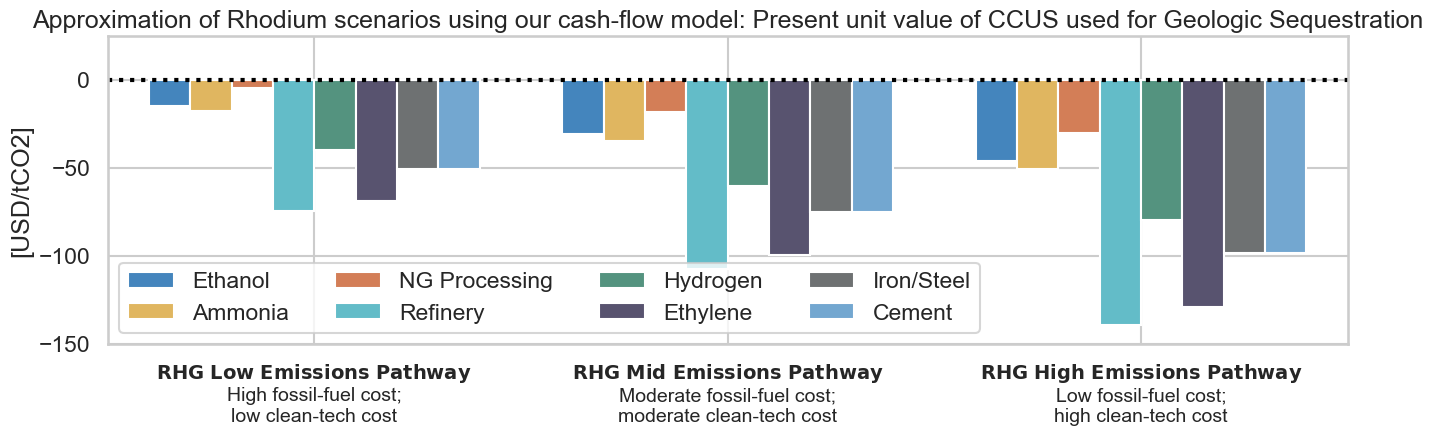

In [16]:
sns.set_style("whitegrid", {"axes.grid": True})
sns.set_context("talk")

palette = {
    "Ethanol": rgb_tuple(68, 133, 189),
    "Ammonia": rgb_tuple(224, 182, 96),
    "NG Processing": rgb_tuple(211, 126, 87),
    "Refinery": rgb_tuple(99, 188, 200),
    "Hydrogen": rgb_tuple(84, 147, 127),
    "Ethylene": rgb_tuple(88, 83, 111),
    "Iron/Steel": rgb_tuple(110, 113, 114),
    "Cement": rgb_tuple(115, 167, 208),
}
hue_order = list(palette.keys())
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.barplot(
    ax=ax,
    data=rhg_scenarios_df,
    x="rhg_emissions_pathway",
    y="total_gs_usd_per_tco2",
    hue="industry",
    palette=palette,
    hue_order=hue_order,
    saturation=1,
)
plt.plot([-0.5, 2.5], [0, 0], "k", lw=3, ls=":")
ax.set_xlim([-0.5, 2.5])
ax.set_ylim([-150, 25])
ax.grid(True)
labels = ax.get_xticklabels()
ax.set_xticklabels(
    [
        r"$\bf{"
        + "RHG\ Low\ Emissions\ Pathway"
        + "}$"
        + "\nHigh fossil-fuel cost;\nlow clean-tech cost",
        r"$\bf{"
        + "RHG\ Mid\ Emissions\ Pathway"
        + "}$"
        + "\nModerate fossil-fuel cost;\nmoderate clean-tech cost",
        r"$\bf{"
        + "RHG\ High\ Emissions\ Pathway"
        + "}$"
        + "\nLow fossil-fuel cost;\nhigh clean-tech cost",
    ],
    fontsize=14,
)
ax.set_xlabel("")
ax.set_ylabel("[USD/tCO2]")
ax.set_title(
    "Approximation of Rhodium scenarios using our cash-flow model: Present unit value of CCUS used for Geologic Sequestration"
)
ax.legend(loc="lower left", ncols=4)

### Figure showing the distance to the nearest storage region and the count of different industry facilities in each region

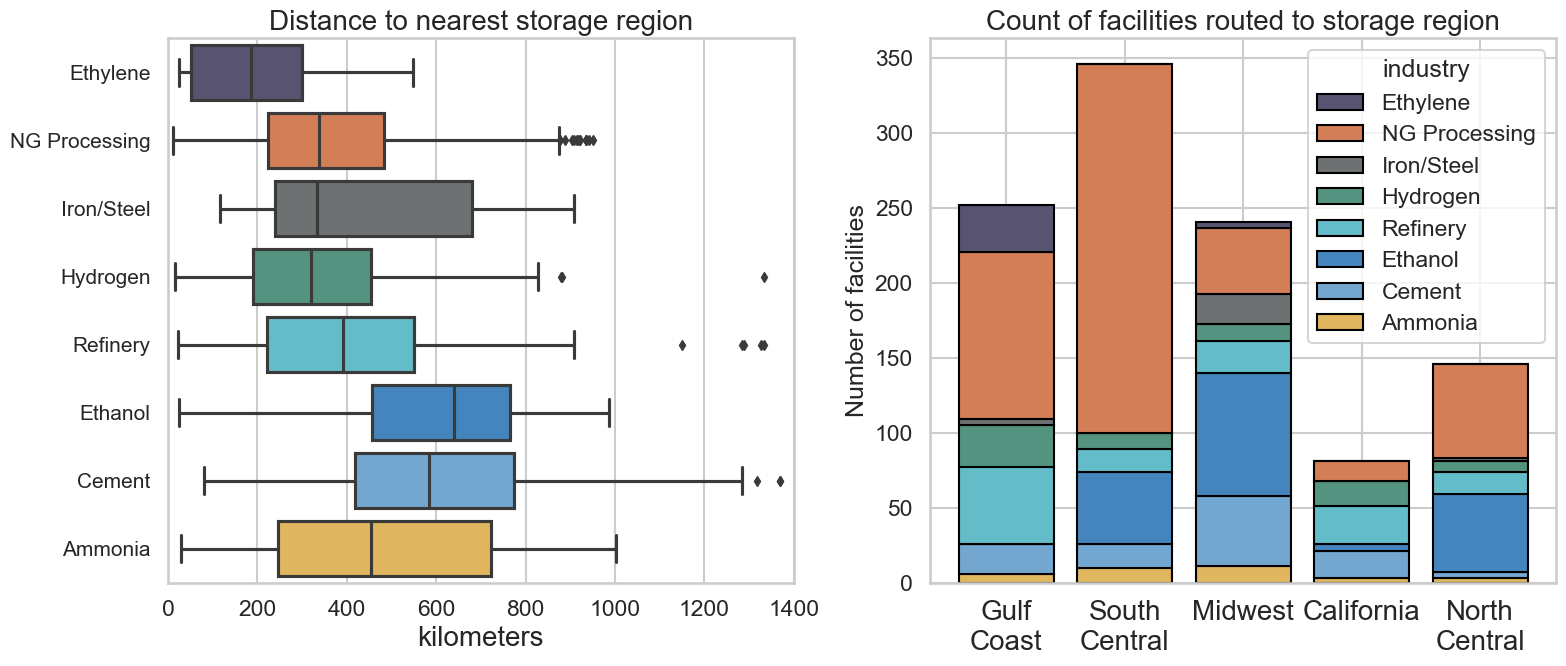

In [19]:
sns.set_context("talk")  # rc={"patch.linewidth": 1, "patch.edgecolor": "gray"})
sns.set_style("whitegrid")
hue_order = list(
    all_industries_gdf[["industry", "dist_to_storage_km"]]
    .groupby("industry")
    .mean()
    .sort_values(by="dist_to_storage_km")
    .index
)

regions = list(all_industries_gdf.storage_region.unique())

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.boxplot(
    data=all_industries_gdf,
    x="dist_to_storage_km",
    y="industry",
    ax=axes[0],
    palette=palette,
    order=hue_order,
    saturation=1,
)
axes[0].set_title("Distance to nearest storage region", fontsize=20)
axes[0].set_xlim([0, 1400])
axes[0].set_ylabel("")
axes[0].set_xlabel("kilometers", fontsize=20)
axes[0].set_yticklabels(labels=hue_order, fontsize=15)

# create stacked bar chart shwoing count of facilities routing to each region
sns.histplot(
    data=all_industries_gdf,
    x="storage_region",
    multiple="stack",
    shrink=0.8,
    hue="industry",
    alpha=1,
    ax=axes[1],
    palette=palette,
    hue_order=hue_order,
    ec="black",
)
axes[1].set_title("Count of facilities routed to storage region", fontsize=20)
axes[1].set_ylabel("Number of facilities")
axes[1].set_xlabel("")
axes[1].set_xticklabels([r.replace("_", "\n").title() for r in regions], fontsize=20)
fig.tight_layout()

### Figure showing three example oil-price paths, randomly sampled from the 365-day-rolling-average values in brent_df

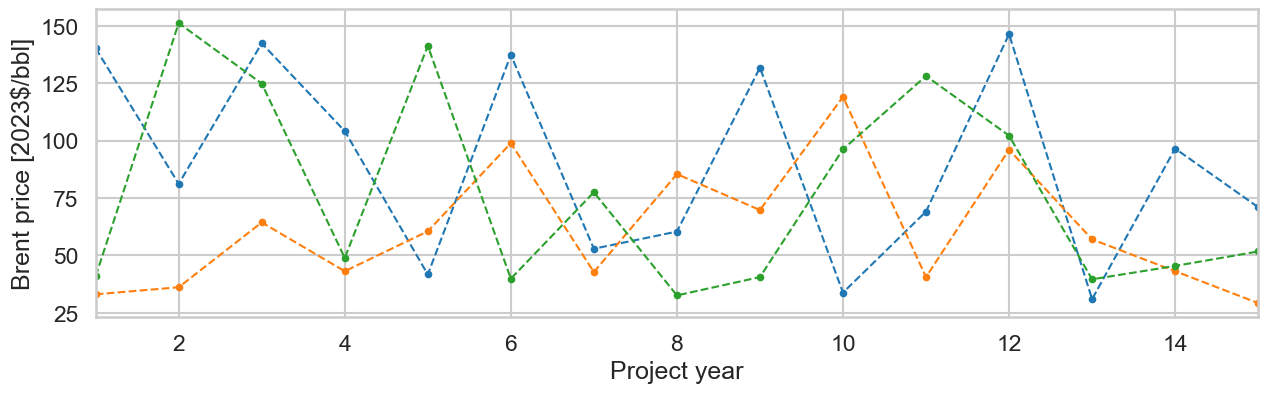

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
plt.subplot(1, 1, 1)
for _ in range(3):
    oil_sample = list(
        brent_df.dropna().rolling_annual_average_usd_per_unit.sample(15, replace=True)
    )
    plt.plot(list(range(1, 16)), oil_sample, marker=".", linestyle="--", lw=1.5)
    plt.xlabel("Project year")
    plt.xlim([1, 15])
    plt.ylabel("Brent price [2023$/bbl]")

### Horizontal figure for presentations looking at present value of CCS-EOR projects to operator by industry

Text(0.5, 1.0, 'Present value of CCS retrofit projects where CO2 is injected to enhance oil recovery for existing wells')

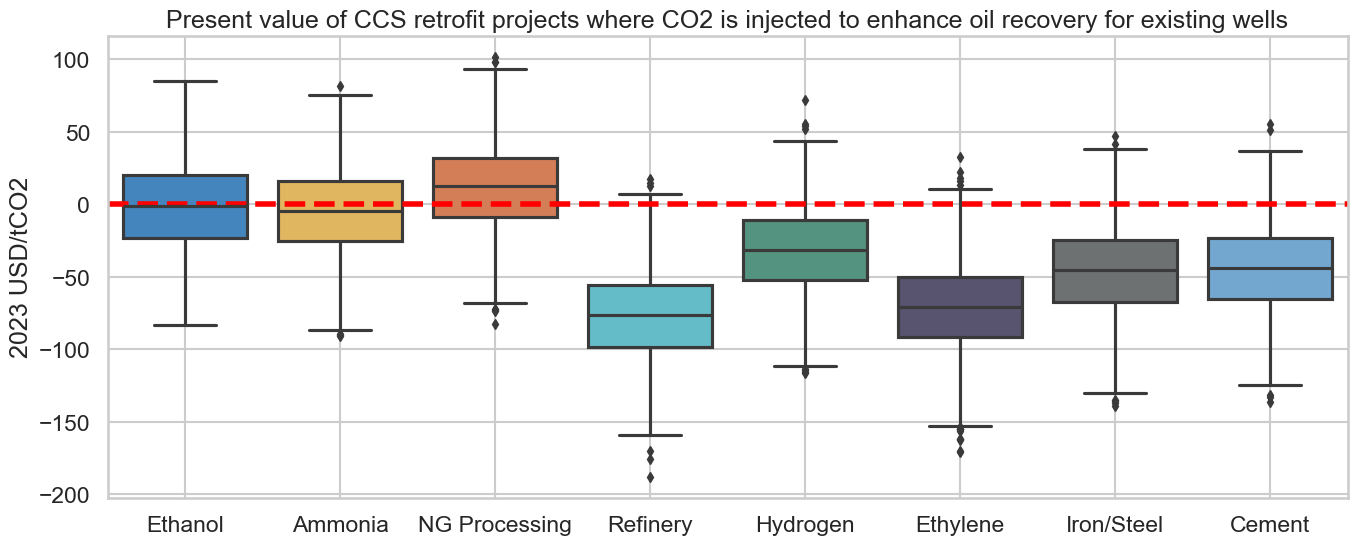

In [23]:
sns.set_style("whitegrid", {"axes.grid": True})
sns.set_context("talk")

hue_order = list(palette.keys())
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.boxplot(
    ax=ax,
    data=scenarios_df.loc[
        (scenarios_df.brent_since_yr == "1987") & (scenarios_df.well_type == "existing")
    ],
    x="industry",
    y="total_eor_usd_per_tco2",
    # hue="well_type",
    palette=palette,
    order=hue_order,
    saturation=1,
)
plt.plot([-0.5, 7.5], [0, 0], "r", lw=4, ls="--")
ax.set_xlim([-0.5, 7.5])
ax.grid(True)
ax.set_ylabel("2023 USD/tCO2")
ax.set_xlabel("")
ax.set_title(
    "Present value of CCS retrofit projects where CO2 is injected to enhance oil recovery for existing wells"
)

### Figure for Rhodium Analysis Blog post reporting results/comparing CCS with geologic storage and CCS with EOR

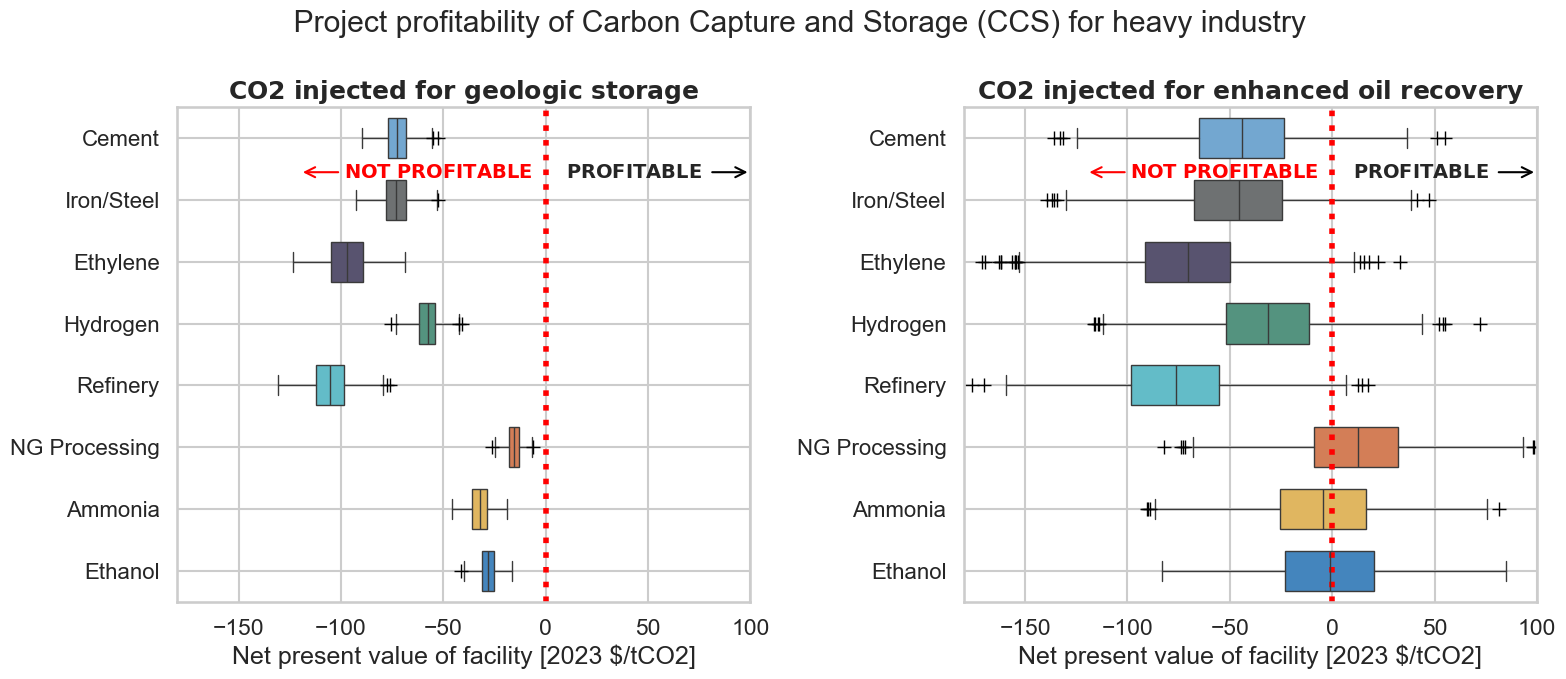

In [34]:
sns.set_style("whitegrid", {"axes.grid": True})
sns.set_context("talk")


hue_order = list(palette.keys())
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
flierprops = dict(
    marker="+", markerfacecolor="None", markersize=10, markeredgecolor="black"
)
for i, var in enumerate(["total_gs_usd_per_tco2", "total_eor_usd_per_tco2"]):
    sns.boxplot(
        ax=axes[i],
        data=scenarios_df.loc[
            (scenarios_df.brent_since_yr == "1987")
            & (scenarios_df.well_type == "existing")
        ],
        y="industry",
        x=var,
        width=0.65,
        palette=palette,
        order=hue_order,
        saturation=1,
        flierprops=flierprops,
        linewidth=1,
        dodge=True,
    )
    plt.subplot(1, 2, i + 1)
    plt.plot([0, 0], [-0.5, 7.5], "r", lw=4, ls=":")
    axes[i].set_ylim([-0.5, 7.5])
    axes[i].set_xlim([-180, 100])
    axes[i].grid(True)
    axes[i].set_ylabel("")
    axes[i].set_xlabel("Net present value of facility [2023 $/tCO2]", fontsize=18)
    l = axes[i].get_yticklabels()
    axes[i].set_yticklabels(labels=l, fontsize=16)
    axes[i].annotate(
        r"$\bf{" + "PROFITABLE" + "}$",
        xy=(280, 305),
        xycoords="axes points",
        fontsize=14,
    )
    axes[i].annotate(
        r"$\bf{" + "NOT\ PROFITABLE" + "}$",
        xy=(120, 305),
        xycoords="axes points",
        color="r",
        fontsize=14,
    )
    axes[i].annotate(
        "",
        xy=(100, 6.45),
        xytext=(80, 6.45),
        arrowprops=dict(arrowstyle="->") | dict(color="k"),
    )
    axes[i].annotate(
        "",
        xy=(-120, 6.45),
        xytext=(-100, 6.45),
        arrowprops=dict(arrowstyle="->") | dict(color="r"),
    )
    if i == 0:
        axes[i].set_title(
            r"$\bf{" + "CO2\ injected\ for\ geologic\ storage" + "}$",
        )
    else:
        axes[i].set_title(
            r"$\bf{" + "CO2\ injected\ for\ enhanced\ oil\ recovery" + "}$",
        )
fig.suptitle(
    "    Project profitability of Carbon Capture and Storage (CCS) for heavy industry"
)
fig.tight_layout()

### Figure comparing distributions for ensembles for new and existing wells

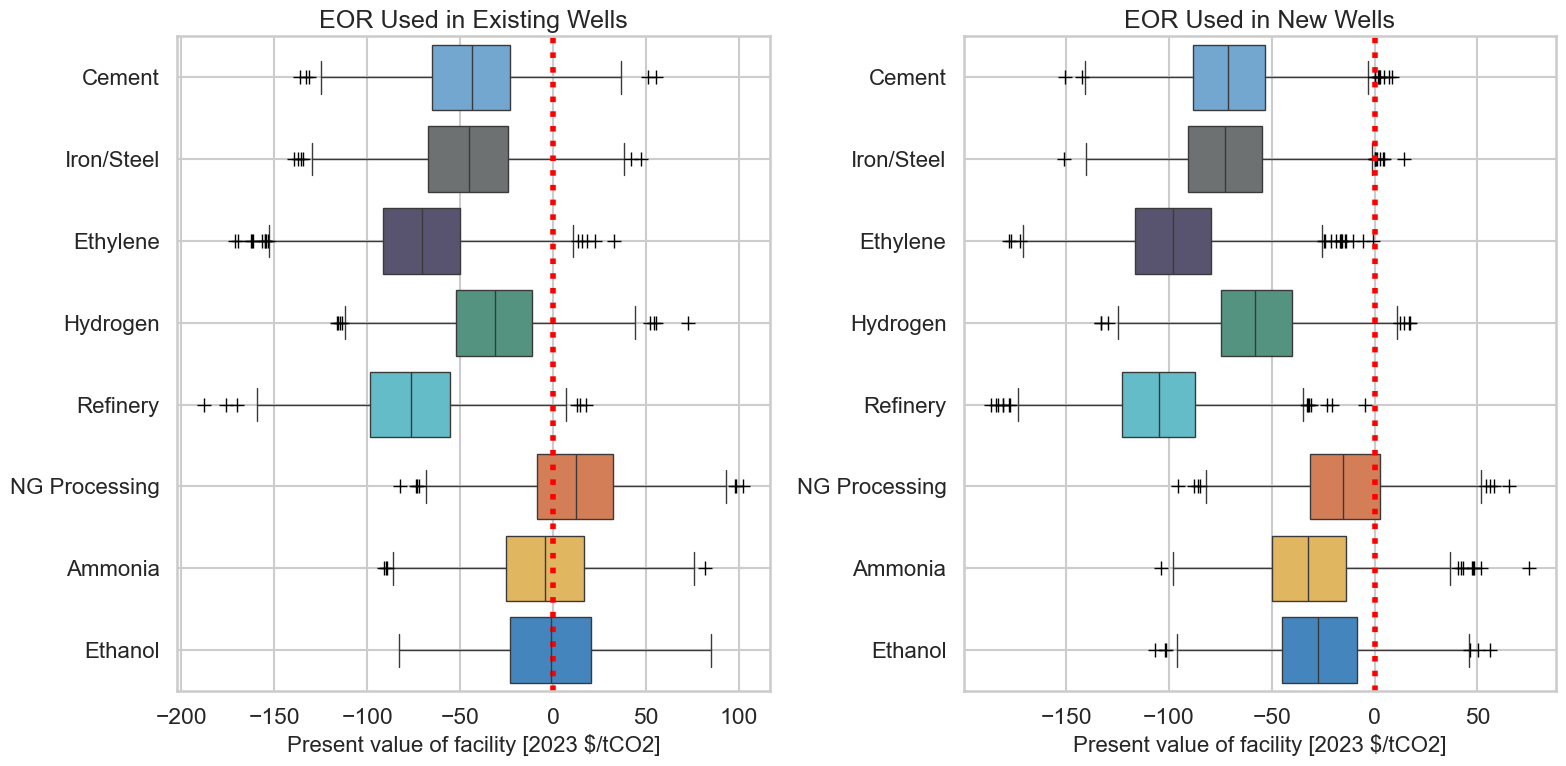

In [25]:
sns.set_style("whitegrid", {"axes.grid": True})
sns.set_context("talk")


hue_order = list(palette.keys())
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
flierprops = dict(
    marker="+", markerfacecolor="None", markersize=10, markeredgecolor="black"
)
for i, well_type in enumerate(["existing", "new"]):
    sns.boxplot(
        ax=axes[i],
        data=scenarios_df.loc[
            (scenarios_df.brent_since_yr == "1987")
            & (scenarios_df.well_type == well_type)
        ],
        y="industry",
        x="total_eor_usd_per_tco2",
        palette=palette,
        order=hue_order,
        saturation=1,
        flierprops=flierprops,
        linewidth=1,
    )
    plt.subplot(1, 2, i + 1)
    plt.plot([0, 0], [-0.5, 7.5], "r", lw=4, ls=":")
    axes[i].set_ylim([-0.5, 7.5])
    axes[i].grid(True)
    axes[i].set_ylabel("")
    axes[i].set_xlabel("Present value of facility [2023 $/tCO2]", fontsize=16)
    l = axes[i].get_yticklabels()
    axes[i].set_yticklabels(labels=l, fontsize=16)
    axes[i].set_title("EOR Used in " + well_type.title() + " Wells")
fig.tight_layout()

### Sensitivity tests: Figure comparing distributions for ensembles for new and existing wells, separating by years of brent sampled

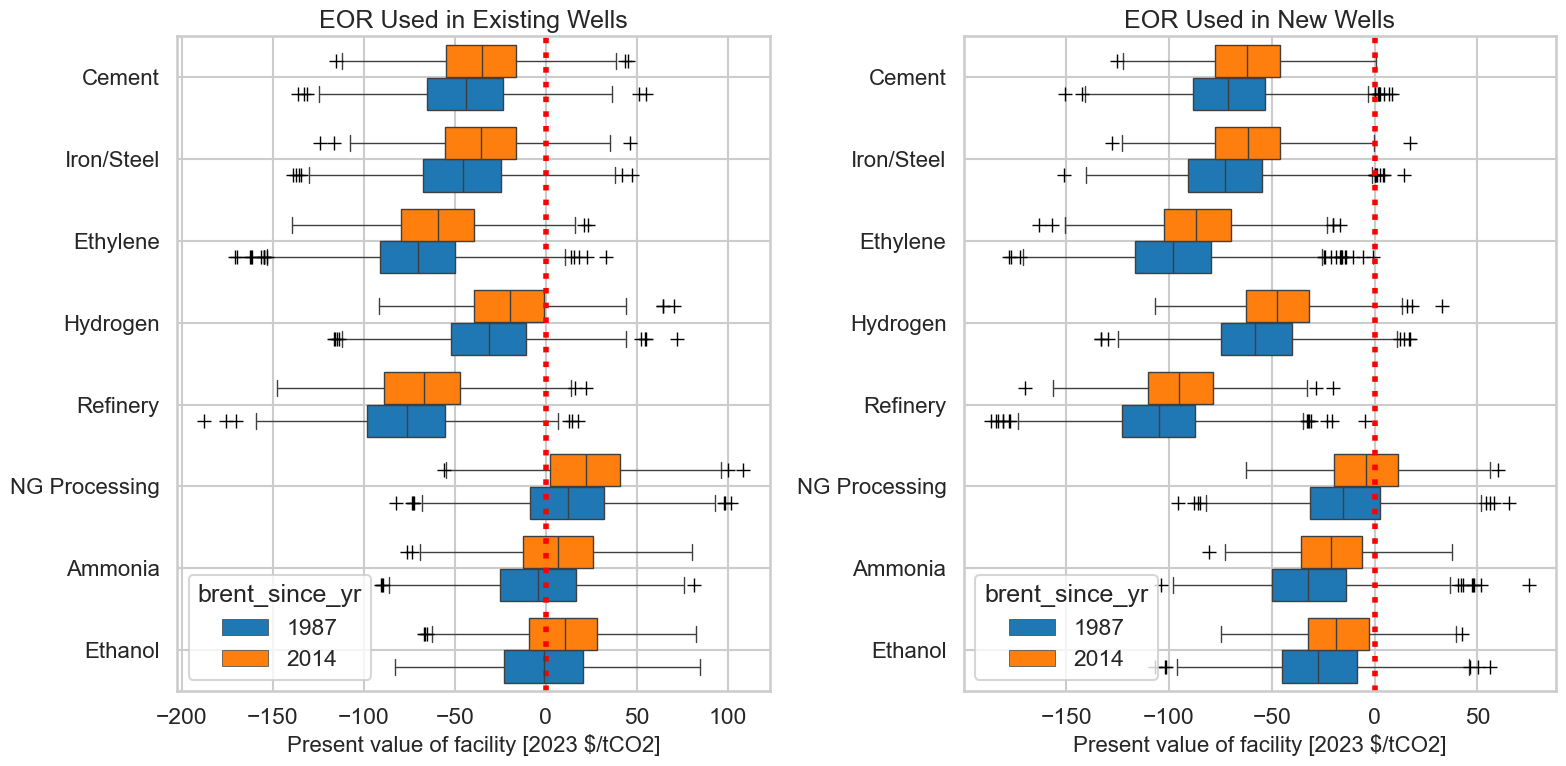

In [26]:
sns.set_style("whitegrid", {"axes.grid": True})
sns.set_context("talk")


hue_order = list(palette.keys())
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
flierprops = dict(
    marker="+", markerfacecolor="None", markersize=10, markeredgecolor="black"
)
for i, well_type in enumerate(["existing", "new"]):
    sns.boxplot(
        ax=axes[i],
        data=scenarios_df.loc[
            # (scenarios_df.brent_since_yr == "1987") &
            (scenarios_df.well_type == well_type)
        ],
        y="industry",
        x="total_eor_usd_per_tco2",
        hue="brent_since_yr",
        # palette=palette,
        order=hue_order,
        saturation=1,
        flierprops=flierprops,
        linewidth=1,
    )
    plt.subplot(1, 2, i + 1)
    plt.plot([0, 0], [-0.5, 7.5], "r", lw=4, ls=":")
    axes[i].set_ylim([-0.5, 7.5])
    axes[i].grid(True)
    axes[i].set_ylabel("")
    axes[i].set_xlabel("Present value of facility [2023 $/tCO2]", fontsize=16)
    l = axes[i].get_yticklabels()
    axes[i].set_yticklabels(labels=l, fontsize=16)
    axes[i].set_title("EOR Used in " + well_type.title() + " Wells")
fig.tight_layout()

### Write out a summary table for ensemble

In [27]:
scenarios_df["eor_gt_0"] = [x > 0 for x in scenarios_df.total_eor_usd_per_tco2]
scenarios_df["gs_gt_0"] = [x > 0 for x in scenarios_df.total_gs_usd_per_tco2]

scenarios_df[
    [
        "industry",
        "brent_since_yr",
        "well_type",
        "eor_gt_0",
        "gs_gt_0",
        "total_eor_usd_per_tco2",
        "total_gs_usd_per_tco2",
    ]
].loc[scenarios_df.brent_since_yr == "1987"].groupby(
    ["brent_since_yr", "industry", "well_type"]
).mean().to_csv(
    "~/Desktop/ccs_results.csv"
)

In [30]:
install_df = pd.read_csv(
    "/Volumes/Samsung_T5/data/ccs_economics/6kw_solar_array_install_cost.csv"
)

In [31]:
solar_df[["region", "state", "installation_cost_usd", "usd_per_kwh"]].groupby(
    "state"
).first().reset_index().to_csv("~/Desktop/solar_costs.csv")

### How 'good' an investment CCS- EOR is 

In [32]:
# Because the combustion of oil produced by EOR releases 1.5 tCO2 for every 1 tCO2 injected, the most charitable way to report emissions 'savings' is by multiplying the
# cost of CCS-EOR per tCO2 by 2.
unit_cost_to_govt_of_ccseor = (
    scenarios_df.loc[
        (scenarios_df.well_type == "existing") & (scenarios_df.brent_since_yr == "1987")
    ].pv_eor_subsidy_unit_revenue_usd_per_tco2.mean()
    * 2
)
unit_npv_of_ccs_to_project_developers = scenarios_df.loc[
    (scenarios_df.well_type == "existing")
    & (scenarios_df.brent_since_yr == "1987")
    & (scenarios_df.industry == "NG Processing")
].total_eor_usd_per_tco2.mean()
print(
    f"Unit cost of CCS-EOR for Natural Gas Processing to the government is ${unit_cost_to_govt_of_ccseor:.2f}/tCO2 averted"
)
print(
    f"Unit NPV of CCS-EOR for Natural Gas Processing CCS project developers is ${unit_npv_of_ccs_to_project_developers:.2f}/tCO2 averted"
)
# A $10 billion federal investment will remove how many tons of CO2 from the air over the project lifetime?
print(
    f"Over project lifetimes, a $10 billion federal investment in NGP with CCS-EOR will (optimistically) reduce emissions by {10000000000 / 59.17264353697795:.0f} tCO2"
)
print(
    f"Those same CCS-EOR projects will have an NPV of ${unit_npv_of_ccs_to_project_developers * (10000000000 / 59.17264353697795):.0f} to corporate project developers."
)
print("")

Unit cost of CCS-EOR for Natural Gas Processing to the government is $59.17/tCO2 averted
Unit NPV of CCS-EOR for Natural Gas Processing CCS project developers is $11.71/tCO2 averted
Over project lifetimes, a $10 billion federal investment in NGP with CCS-EOR will (optimistically) reduce emissions by 168997013 tCO2
Those same CCS-EOR projects will have an NPV of $1979417362 to corporate project developers.



## How 'good' and investment solar is

### Stats about solar value to homeowners

In [118]:
print(
    f"Average project-lifetime NPV of rooftop solar (USD): {solar_df.npv_homeowner_usd.mean():.2f}"
)
print(
    f"Average project-lifetime NPV of rooftop solar (USD/tCO2 averted): {solar_df.npv_homeowner_usd_per_tco2.mean():.2f}"
)

Average project-lifetime NPV of rooftop solar (USD): 7895.02
Average project-lifetime NPV of rooftop solar (USD/tCO2 averted): 74.45


In [33]:
unit_cost_to_govt_of_solar = solar_df.pv_govt_expense_usd_per_tco2.mean()
npv_solar_to_homeowners = solar_df.npv_homeowner_usd_per_tco2.mean()
print(
    f"Unit cost of rooftop-solar carbon-emission avoidance to the government is ${unit_cost_to_govt_of_solar:.2f}/tCO2 averted"
)
print(
    f"Unit NPV of rooftop-solar to homeowners is ${npv_solar_to_homeowners:.2f}/tCO2 averted"
)
# A $10 billion federal investment will remove how many tons of CO2 from the air over the project lifetime?
print(
    f"Over project lifetimes, a $10 billion federal investment in rooftop solar will reduce emissions by {10000000000 / unit_cost_to_govt_of_solar:.0f} tCO2"
)
print(
    f"Those same rooftop solar investments will have an NPV of ${npv_solar_to_homeowners * (10000000000 / unit_cost_to_govt_of_solar):.0f} to home owners."
)
print("")

Unit cost of rooftop-solar carbon-emission avoidance to the government is $48.81/tCO2 averted
Unit NPV of rooftop-solar to homeowners is $74.45/tCO2 averted
Over project lifetimes, a $10 billion federal investment in rooftop solar will reduce emissions by 204857992 tCO2
Those same rooftop solar investments will have an NPV of $15251109705 to home owners.



### CRCJ Fig 1: Brent crude prices through time and distribution of daily prices

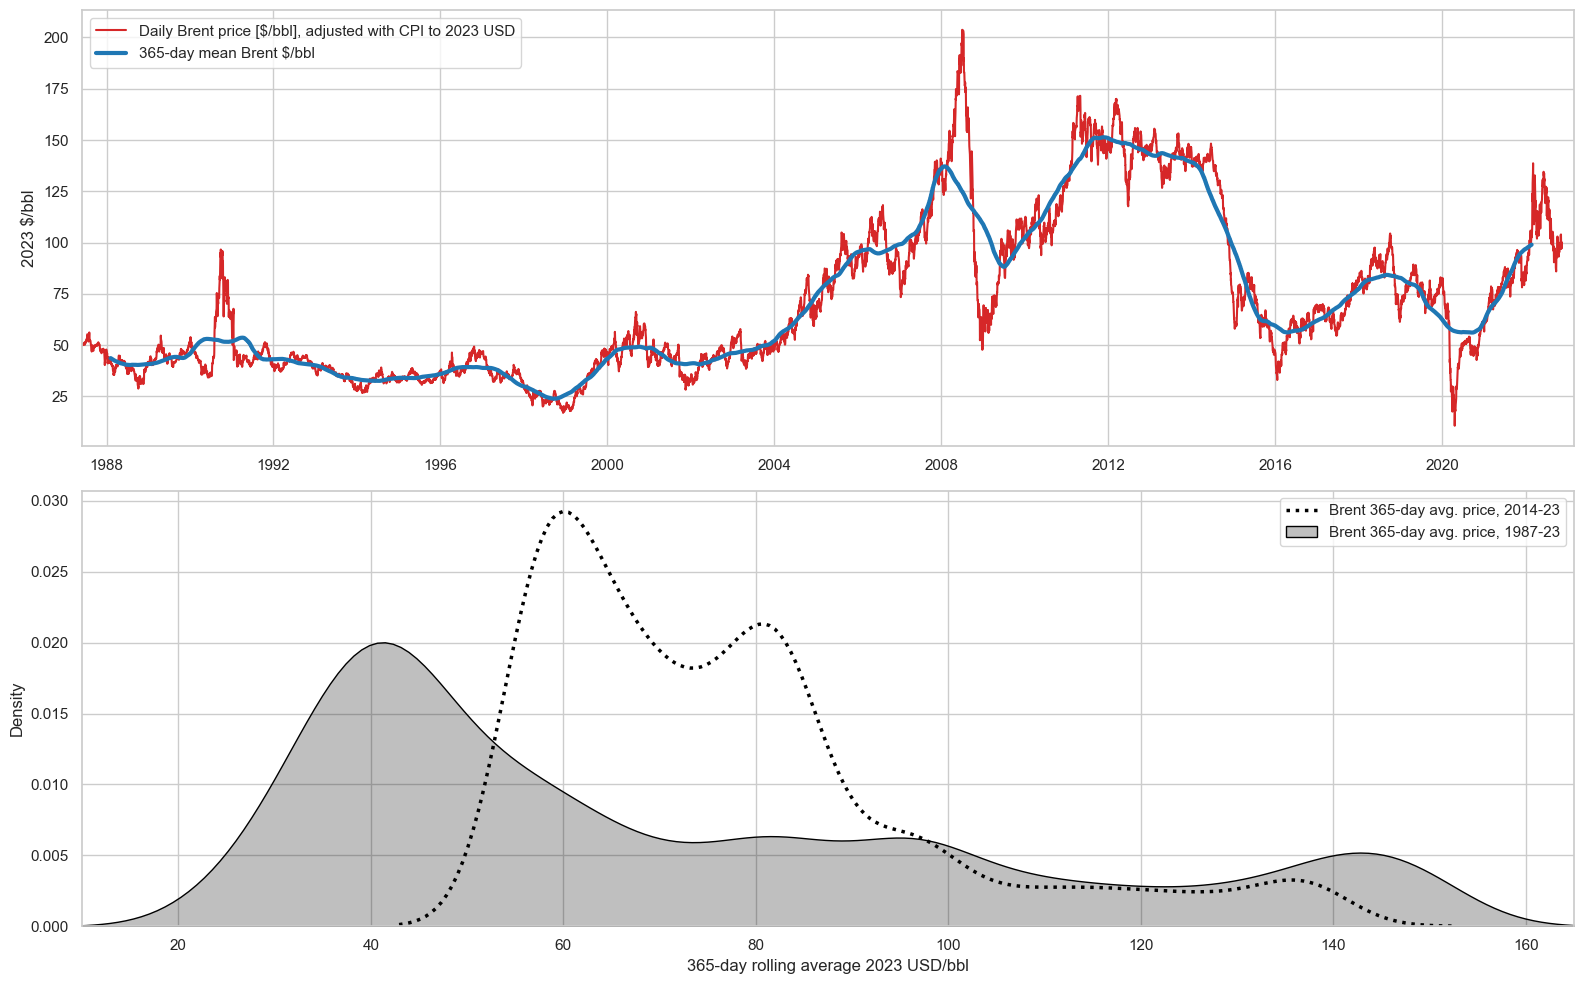

In [114]:
sns.set_context("notebook")
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
ax = axes[0]

ax.plot(
    brent_df.date,
    brent_df.usd_cpi_2023,
    color="tab:red",
    lw=1.5,
    label="Daily Brent price [$/bbl], adjusted with CPI to 2023 USD",
)
ax.plot(
    brent_df.date,
    brent_df.rolling_annual_average_usd_per_unit,
    color="tab:blue",
    lw=3,
    label="365-day mean Brent $/bbl",
)
ax.grid(True)
ax.set_ylabel("2023 $/bbl")
ax.legend(loc="upper left")
ax.set_xlim([dt.datetime(1987, 6, 1), dt.datetime(2023, 3, 1)])


ax = axes[1]
# Turn rhg oil price cases into a long-form dataset so that we can use seaborn's hue functionalty
rhg_cases_longform_df = rhg_oil_cases_df.melt(
    value_vars=["low", "mid", "high"],
    value_name="usd_per_bbl",
    var_name="rhg_emissions_case",
)

common_norm = False

# --- Distribution of brent prices

ax.set_xlim([10, 165])
sns.kdeplot(
    data=brent_df.loc[(brent_df["year"] > 2013)],
    x="rolling_annual_average_usd_per_unit",
    common_norm=common_norm,
    fill=False,
    ax=ax,
    ls=":",
    lw=2.5,
    color="black",
    label="Brent 365-day avg. price, 2014-23",
)

sns.kdeplot(
    data=brent_df.loc[(brent_df["year"] > 1986)],
    x="rolling_annual_average_usd_per_unit",
    common_norm=common_norm,
    fill=True,
    ax=ax,
    color="black",
    label="Brent 365-day avg. price, 1987-23",
)
l = ax.get_yticklabels()
# ax.set_yticklabels(l, fontsize=13)
ax.legend(loc="upper right")
ax.grid(True)
ax.set_xlabel("365-day rolling average 2023 USD/bbl")
fig.tight_layout()
fig.savefig("figure_1.pdf")

### CRCJ Fig 2: Figure plotting empirical approximations of triangular distributions for oil breakeven price

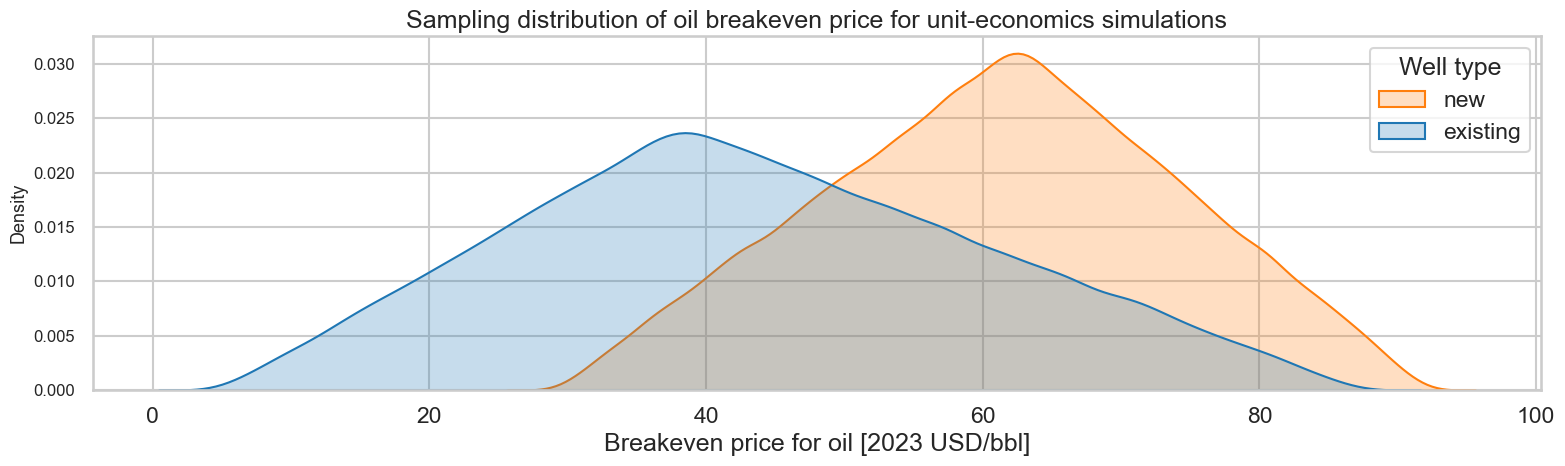

In [110]:
breakeven_distributions_df = pd.DataFrame(
    {
        "existing": np.random.triangular(
            left=breakeven_prices_df.loc["existing", "low"],
            mode=breakeven_prices_df.loc["existing", "mid"],
            right=breakeven_prices_df.loc["existing", "high"],
            size=150000,
        ),
        "new": np.random.triangular(
            left=breakeven_prices_df.loc["new", "low"],
            mode=breakeven_prices_df.loc["new", "mid"],
            right=breakeven_prices_df.loc["new", "high"],
            size=150000,
        ),
    }
).melt(
    value_vars=["existing", "new"],
    var_name="well type",
    value_name="breakeven_usd_per_bbl",
)

sns.set_context("talk")
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
sns.kdeplot(
    data=breakeven_distributions_df,
    x="breakeven_usd_per_bbl",
    hue="well type",
    common_norm=False,
    fill=True,
    ax=ax,
)
ax.legend(
    title="Well type",
    labels=[
        "new",
        "existing",
    ],
)
ax.set_title(
    "Sampling distribution of oil breakeven price for unit-economics simulations"
)
ax.set_xlabel("Breakeven price for oil [2023 USD/bbl]")
l = ax.get_yticklabels()
ax.set_yticklabels(labels=l, fontsize=12)
ax.set_ylabel("Density", fontsize=13)
ax.grid("on")
fig.tight_layout()
fig.savefig("figure_2.pdf")

### CRCJ Fig 3, 5 and 6: showing sampling distributions for CCS costs

['Ethanol', 'Ammonia', 'NG Processing', 'Refinery', 'Hydrogen', 'Ethylene', 'Iron/Steel', 'Cement', 'Rooftop Solar']


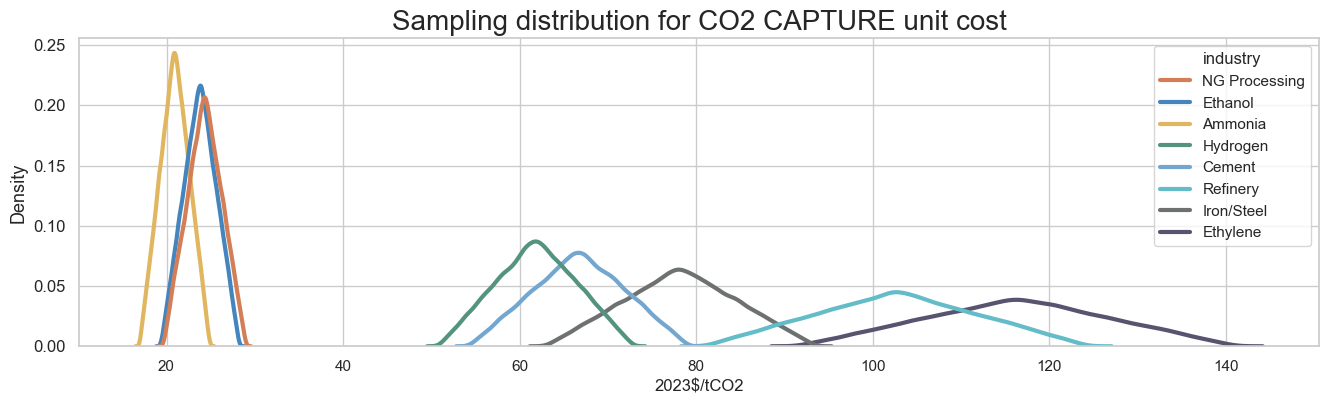

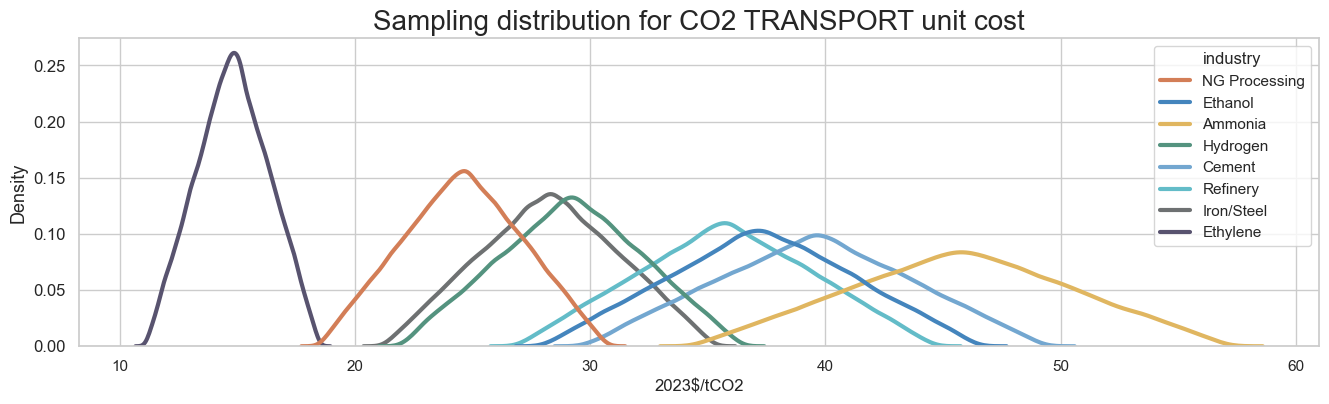

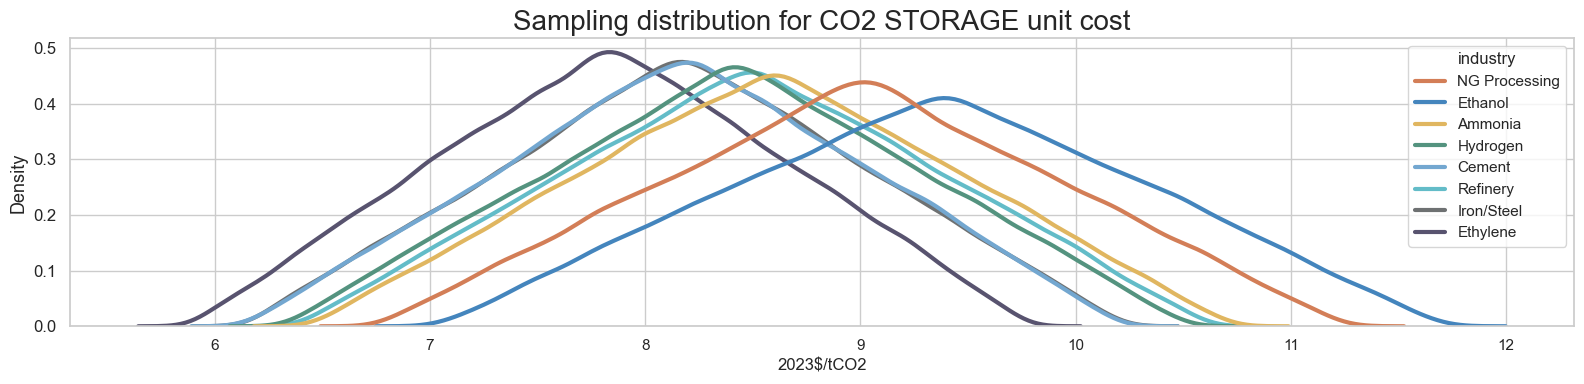

In [109]:
linestyle_dict = {
    "Ethanol": "--",
    "Ammonia": "-",
    "NG Processing": "-.",
    "Refinery": ":",
    "Hydrogen": "-",
    "Ethylene": "--",
    "Iron/Steel": "-.",
    "Cement": ":",
    "Rooftop Solar": "-",
}
# build empirical representations of the triangular distributions used for PDFs for capture, transport, and storage costs
cost_dict = {}
transport_dict = {}
stor_dict = {}
for industry in industries:
    cost_dict = cost_dict | {
        industry: np.random.triangular(
            left=costs_df.loc[industry, "capture_low_usd_per_tco2"],
            mode=costs_df.loc[industry, "capture_center_usd_per_tco2"],
            right=costs_df.loc[industry, "capture_high_usd_per_tco2"],
            size=100000,
        )
    }
    transport_dict = transport_dict | {
        industry: np.random.triangular(
            left=costs_df.loc[industry, "transport_usd_per_tco2"] * 0.75,
            mode=costs_df.loc[industry, "transport_usd_per_tco2"],
            right=costs_df.loc[industry, "transport_usd_per_tco2"] * 1.25,
            size=100000,
        )
    }
    stor_dict = stor_dict | {
        industry: np.random.triangular(
            left=costs_df.loc[industry, "storage_usd_per_tco2"] * 0.75,
            mode=costs_df.loc[industry, "storage_usd_per_tco2"],
            right=costs_df.loc[industry, "storage_usd_per_tco2"] * 1.25,
            size=100000,
        )
    }
# assemble dictionaries into dataframes, longform for seaborn plotting
cost_distributions_df = pd.DataFrame(cost_dict)
cost_distributions_df["NG Processing"] = (
    cost_distributions_df["NG Processing"] + 0.5
)  # so visible on plot
cost_distributions_df = cost_distributions_df.melt(
    value_vars=industries,
    var_name="industry",
    value_name="capture_cost_usd_per_tco2",
)

transport_distributions_df = pd.DataFrame(transport_dict).melt(
    value_vars=industries,
    var_name="industry",
    value_name="transport_cost_usd_per_tco2",
)

storage_distributions_df = pd.DataFrame(stor_dict).melt(
    value_vars=industries,
    var_name="industry",
    value_name="storage_cost_usd_per_tco2",
)

sns.set_context("notebook")
hue_order = list(palette.keys())
print(hue_order)
i = 0
for cost, data_df in {
    "capture": cost_distributions_df,
    "transport": transport_distributions_df,
    "storage": storage_distributions_df,
}.items():
    fig, ax = plt.subplots(1, 1, figsize=(16, 4))
    # ax = axes[i]  # get on right plot axis

    sns.kdeplot(
        data=data_df,
        x=cost + "_cost_usd_per_tco2",
        hue="industry",
        palette=palette,
        common_norm=False,
        lw=3,
        fill=False,
        ax=ax,
    )

    for line, ls in zip(ax.collections, list(linestyle_dict.values())):
        line.set_linestyle(ls)

    handles, _ = ax.get_legend_handles_labels()
    for handle, ls in zip(handles[::-1], list(linestyle_dict.values())):
        handle.set_ls(ls)
    # ax.legend(title="industry", labels=hue_order, ncol=2, fontsize=14)
    ax.set_title(f"Sampling distribution for CO2 {cost.upper()} unit cost", fontsize=20)
    # ax.set_xlim([5, 140])
    ax.grid(True)
    # ax.legend(ncol=2)
    ax.set_xlabel("2023$/tCO2")

    l = ax.get_yticklabels()
    ax.set_yticklabels(labels=l, fontsize=12)
    ax.set_ylabel("Density", fontsize=13)
    i += 1
fig.tight_layout()

# ended up using prviously written out fig versions that had line style variations

### CRCJ Fig 4: Figure showing locations of industry facilities used to build average values for transport and storage costs, by industry


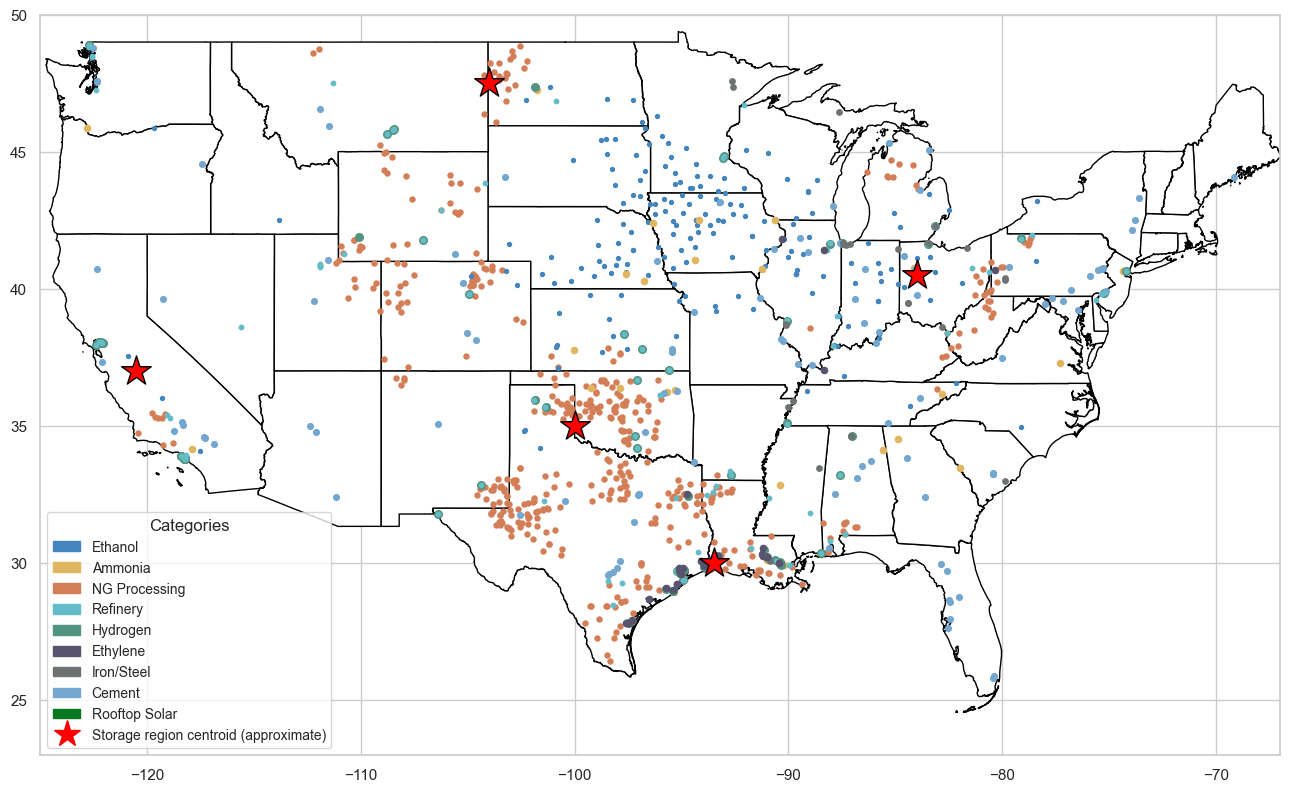

In [112]:
markersize = {
    "Refinery": 10,
    "Ethylene": 20,
    "Ethanol": 8,
    "NG Processing": 13,
    "Ammonia": 20,
    "Cement": 17,
    "Hydrogen": 30,
    "Iron/Steel": 15,
}
us = gpd.read_file("/Volumes/Samsung_T5/data/us_geo/gz_2010_us_040_00_500k.json")
us.to_crs(crs="EPSG:4326", inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
us.plot(ax=ax, color="white", edgecolor="black")
for industry in industries:
    all_industries_gdf.loc[all_industries_gdf.industry == industry].plot(
        ax=ax, color=palette[industry], markersize=markersize[industry], legend=True
    )
storage_gdf.plot(
    ax=ax,
    color="red",
    marker="*",
    edgecolor="k",
    markersize=500,
)
ax.set_xlim([-125, -67])
ax.set_ylim([23, 50])
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

legend_patches = [
    mpatches.Patch(color=color, label=label) for label, color in palette.items()
]


star_patch = Line2D(
    [0],
    [0],
    marker="*",
    color="red",
    linestyle="None",
    markersize=20,
    label="Storage region centroid (approximate)",
)
ax.legend(
    handles=legend_patches + [star_patch],
    title="Categories",
    loc="lower left",
    fontsize=10,
)
fig.savefig("figure_4.pdf")

### CRCJ Fig 7: Figure showing locations of simulated solar arrays, plotted with centroids of NPC CCS storage regions
 

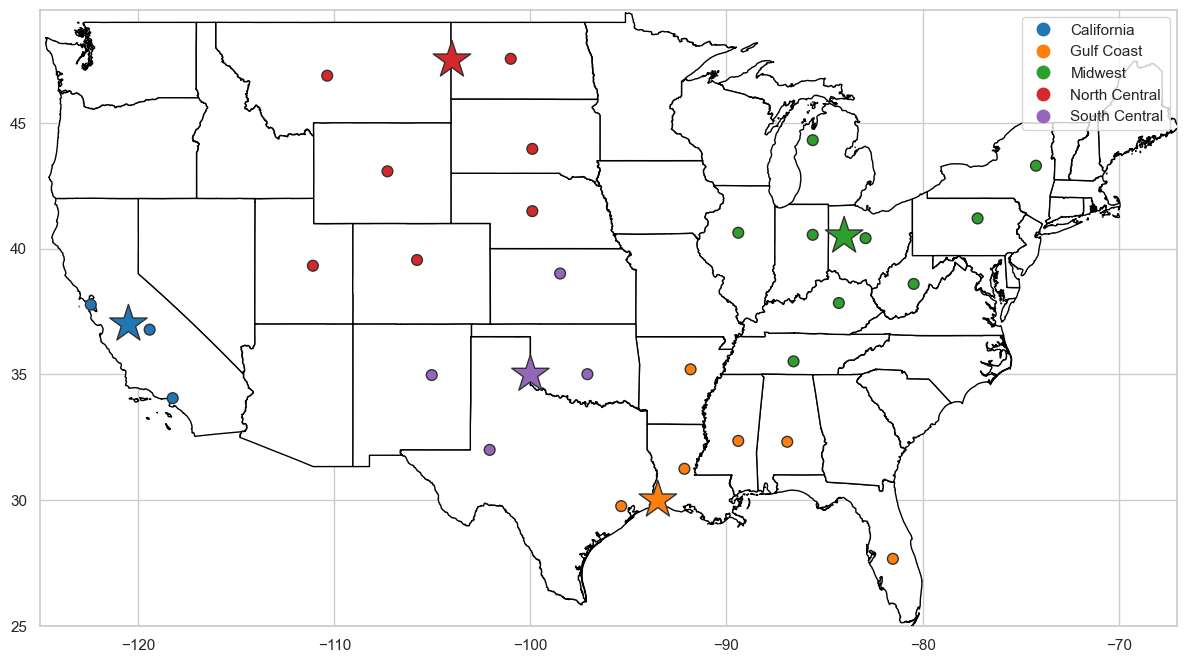

In [115]:
# trunacate the tab10 colormap so we get the right colors by region
cmap = mc.LinearSegmentedColormap.from_list(
    "", ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
)

state_locs_df = pd.read_csv(
    "/Volumes/Samsung_T5/data/ccs_economics/6kw_solar_npc_states_3tilts_9azimuths.csv"
)
state_locs_df = (
    state_locs_df[["state", "lat", "lon", "region"]]
    .groupby("state")
    .first()
    .reset_index()
)
state_locs_df["region"] = [x.title().replace("_", " ") for x in state_locs_df.region]
state_locs_gdf = gpd.GeoDataFrame(
    state_locs_df,
    geometry=gpd.points_from_xy(state_locs_df.lon, state_locs_df.lat),
    crs="EPSG:4326",
)

us = gpd.read_file("/Volumes/Samsung_T5/data/us_geo/gz_2010_us_040_00_500k.json")

us.columns = [x.lower() for x in us.columns.values]
sns.set_context("notebook")
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
us.plot(ax=ax, color="white", edgecolor="black", zorder=3)

state_locs_gdf.plot(
    ax=ax,
    column="region",
    edgecolor=rgb_tuple(50, 50, 50),
    markersize=60,
    colormap=cmap,
    legend=True,
    zorder=4,
)
storage_gdf["region"] = [x.title().replace("_", " ") for x in storage_gdf.region]
storage_gdf.plot(
    ax=ax,
    column="region",
    marker="*",
    colormap=cmap,
    edgecolor=rgb_tuple(50, 50, 50),
    markersize=800,
    zorder=5,
)
ax.grid(zorder=0)
ax.set_xlim([-125, -67])
ax.set_ylim([25, 49.5])
fig.savefig("figure_7.pdf")

### CRCJ Fig. 9: Summary plot comparing Solar to CCS-GS

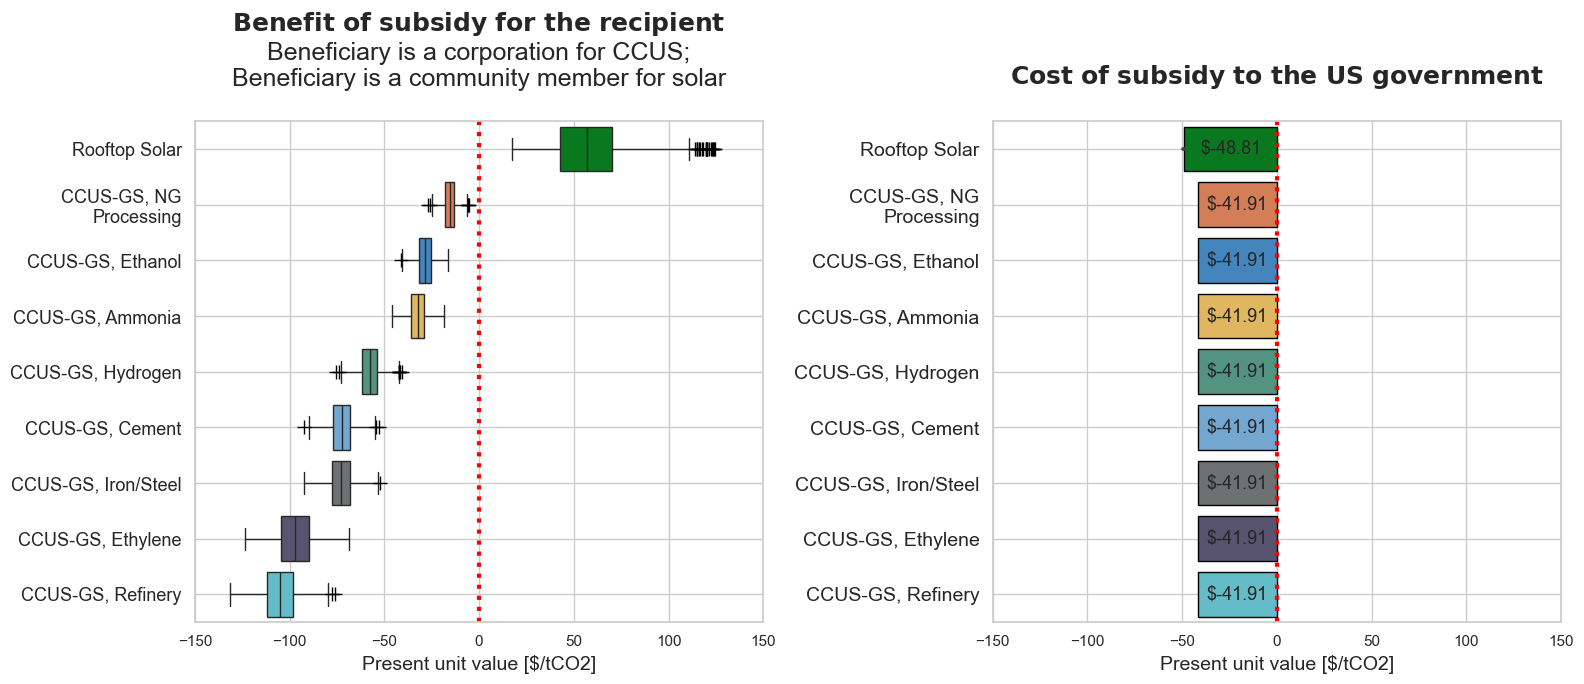

In [113]:
# prepare solar cost data (distribution of all solar cost estiamtes across US)
solar_data_df = pd.DataFrame(
    solar_df[["npv_homeowner_usd_per_tco2", "pv_govt_expense_usd_per_tco2"]]
)
solar_data_df.columns = [
    "beneficiary_pv_usd_per_tco2",
    "pv_cost_to_us_govt_usd_per_tco2",
]
solar_data_df["industry"] = "Rooftop Solar"
solar_data_df = solar_data_df[
    ["industry", "beneficiary_pv_usd_per_tco2", "pv_cost_to_us_govt_usd_per_tco2"]
]


# compute gs data from scenarios run with simulator (across indusries and US)
gs_plot_df = scenarios_df[
    ["industry", "total_gs_usd_per_tco2", "pv_gs_subsidy_unit_revenue_usd_per_tco2"]
].loc[(scenarios_df.brent_since_yr == "1987")]
gs_plot_df.columns = [
    "industry",
    "beneficiary_pv_usd_per_tco2",
    "pv_cost_to_us_govt_usd_per_tco2",
]
gs_plot_df = pd.concat([gs_plot_df, solar_data_df])
# switch magnitude of 'cost' to negative for plotting
gs_plot_df["pv_cost_to_us_govt_usd_per_tco2"] = (
    gs_plot_df["pv_cost_to_us_govt_usd_per_tco2"] * -1
)

# --- plot figure ---
hue_order = list(
    gs_plot_df[["industry", "beneficiary_pv_usd_per_tco2"]]
    .groupby("industry")
    .mean()
    .sort_values(by="beneficiary_pv_usd_per_tco2", ascending=True)
    .index
)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
flierprops = dict(
    marker="+", markerfacecolor="None", markersize=10, markeredgecolor="black"
)
ax = axes[0]
sns.boxplot(
    ax=ax,
    data=gs_plot_df,
    y="industry",
    x="beneficiary_pv_usd_per_tco2",
    # hue="well_type",
    palette=palette,
    order=hue_order,
    saturation=1,
    flierprops=flierprops,
    linewidth=1,
)
plt.subplot(1, 2, 1)
plt.plot([0, 0], [-0.5, 8.5], "r", lw=3, ls=":")
ax.set_ylim([-0.5, 8.5])
ax.set_xlim([-150, 150])
ax.grid(True)
ax.set_xlabel("Present unit value [$/tCO2]", fontsize=14)
ax.set_ylabel("")
ax.set_title(
    r"$\bf{"
    + "Benefit\ of\ subsidy\ for\ the\ recipient"
    + "}$"
    + "\nBeneficiary is a corporation for CCUS;\n"
    + "Beneficiary is a community member for solar"
    + "\n",
    fontsize=18,
)
labels = ax.get_yticklabels()
adjusted_labels = [
    f"{t}NG\nProcessing" if l.get_text() == "NG Processing" else f"{t}{l.get_text()}"
    for l, t in zip(labels, ["CCUS-GS, "] * 8 + [""])
]
ax.set_yticklabels(labels=adjusted_labels, fontsize=13)
ax = axes[1]
sns.barplot(
    ax=ax,
    data=gs_plot_df,
    linewidth=1,
    y="industry",
    x="pv_cost_to_us_govt_usd_per_tco2",
    # hue="well_type",
    palette=palette,
    order=hue_order,
    saturation=1,
)

plt.subplot(1, 2, 2)
plt.setp(ax.patches, linewidth=1, edgecolor="k")
plt.plot([0, 0], [-0.5, 8.5], "r", lw=3, ls=":")
ax.set_ylim([-0.5, 8.5])
ax.set_xlim([-150, 150])
ax.grid(True)
ax.set_xlabel("Present unit value [$/tCO2]", fontsize=14)
ax.set_ylabel("")
ax.set_title(
    "\n" + r"$\bf{" + "Cost\ of\ subsidy\ to\ the\ US\ government" + "}$" + "\n",
    fontsize=18,
)
ax.set_yticklabels(labels=adjusted_labels, fontsize=14)
for bars in ax.containers:
    ax.bar_label(bars, fmt="$%.2f", fontsize=13, label_type="center")
fig.tight_layout()
fig.savefig("figure_9.pdf")

### CRCJ Fig 10: Figure showing variation in solar-array performance and cost by region

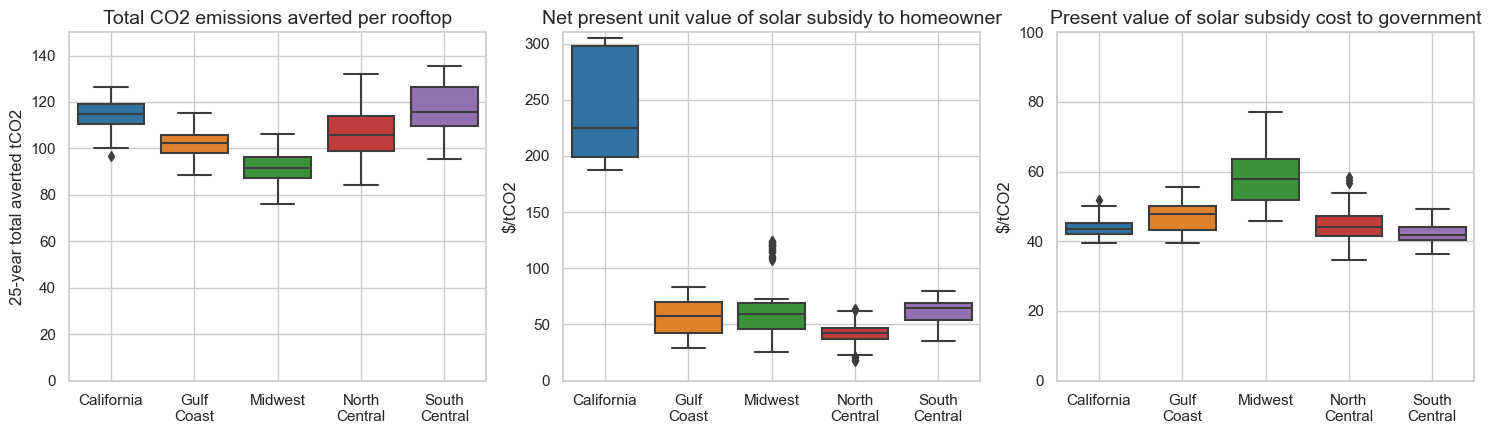

In [111]:
sns.set_context("notebook")
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
solar_df["region_title"] = [x.title().replace("_", "\n") for x in solar_df.region]
regions = sorted(list(solar_df["region_title"].unique()))
titles = [
    "Total CO2 emissions averted per rooftop",
    "Net present unit value of solar subsidy to homeowner",
    "Present value of solar subsidy cost to government",
]
ylabels = ["25-year total averted tCO2", "$/tCO2", "$/tCO2"]
for i, v in enumerate(
    ["total_co2", "npv_homeowner_usd_per_tco2", "pv_govt_expense_usd_per_tco2"]
):
    sns.boxplot(data=solar_df, x="region_title", y=v, ax=axes[i], order=regions)
    axes[i].grid("both")
    axes[i].set_title(titles[i], fontsize=14)
    axes[i].set_ylabel(ylabels[i])
    axes[i].set_xlabel("")
axes[2].set_ylim([0, 100])
axes[1].set_ylim([0, 310])
axes[0].set_ylim([0, 150])
fig.tight_layout()
fig.savefig("figure_10.pdf")